# DESI Data Organization 

# Overview

In this notebook, we will explore the DESI data file structure under a spectroscopic production run. Following notebooks will show more details about reading and using the files.

# Imports

In [1]:
# import some helpful python packages 
import os
import glob
import numpy as np

import fitsio
from astropy.table import Table

import matplotlib 
import matplotlib.pyplot as plt

# plt.style.use('../mpl/desi.mplstyle')

In [2]:
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra

# Spectroscopic Production Directory

First we'll set the location of the "loa" production directory on disk.
We do this once at the beginning to make it easier to switch to other productions
later.

In [3]:
# Release directory path

specprod = 'iron'    # production name for the final Year 3 (Y3) production
desi_root = os.environ['DESI_ROOT']
desi_root_ro = os.environ['DESI_ROOT_READONLY']
specprod_dir = f'{desi_root_ro}/spectro/redux/{specprod}'
print(specprod_dir)

/dvs_ro/cfs/cdirs/desi/spectro/redux/iron


**Pro Tip** (NERSC-specific): in this case we are using `$DESI_ROOT_READONLY` which is a faster read-only mount
of the DESI directory tree, with `$DESI_ROOT` being the normal read/write location.  For exploratory work from a Jupyter notebook the performance gain isn't significant, but it can be big win when scaling up to larger analyses so it is good practice to use `$DESI_ROOT_READONLY` for input files that you are only reading, like the spectroscopic production data.

**Pro Tip** (NERSC-specific): We are also using `$DESI_ROOT_READONLY` instead of hardcoding `/dvs_ro/cfs/cdirs/desi/public/dr1` to make the notebook more portable to other locations, or future NERSC systems that might mount directories differently.

In [4]:
# List everything in this directory
sorted(os.listdir(specprod_dir))

['calibnight',
 'exposure_tables',
 'exposures',
 'exposures-iron.csv',
 'exposures-iron.fits',
 'healpix',
 'inventory-iron.txt',
 'preproc',
 'processing_tables',
 'redux_iron.sha256sum',
 'run',
 'tiles',
 'tiles-iron.csv',
 'tiles-iron.fits',
 'zcatalog']

### Important files to Note:

1. tiles-{specprod}.fits (or .csv) -- This contains information about the observed tiles.
2. exposures-{specprod}.fits (or .csv) -- This consists of information about individual exposures of the targets.
3. zcatalog/ Directory -- This directory contains all of the redshift catalogs.
4. tiles/ Directory -- This directory holds all of the per-tile coadds and redshifts, in various flavors.
5. healpix/ Directory -- This directory holds all of the coadds and redshifts based on sky location (healpix).

## tiles-{specprod}.fits
This file tells you what tiles were observed, what `SURVEY` and `PROGRAM` they were observed for, some observing conditions, and three estimates of the "effective time" (in seconds) that each tile acquired. The time estimate used for survey operations decisions is `EFFTIME_SPEC`. The datamodel for this table is described [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/tiles-SPECPROD.html).

In [5]:
tiles_file = f'{specprod_dir}/tiles-{specprod}.csv'
tiles_table = Table.read(tiles_file)
print(f"{tiles_file} has columns:\n{tiles_table.colnames}")

/dvs_ro/cfs/cdirs/desi/spectro/redux/iron/tiles-iron.csv has columns:
['TILEID', 'SURVEY', 'PROGRAM', 'FAPRGRM', 'FAFLAVOR', 'NEXP', 'EXPTIME', 'TILERA', 'TILEDEC', 'EFFTIME_ETC', 'EFFTIME_SPEC', 'EFFTIME_GFA', 'GOALTIME', 'OBSSTATUS', 'LRG_EFFTIME_DARK', 'ELG_EFFTIME_DARK', 'BGS_EFFTIME_BRIGHT', 'LYA_EFFTIME_DARK', 'GOALTYPE', 'MINTFRAC', 'LASTNIGHT']


See the [tiles file datamodel documentation](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/tiles-SPECPROD.html#hdu1) for what each of those columns mean

In [6]:
tiles_table[100:105]

TILEID,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT
int64,str7,str6,str16,str19,int64,float64,float64,float64,float64,float64,float64,float64,str8,float64,float64,float64,float64,str6,float64,int64
80879,sv1,dark,lrgqso2,sv1lrgqso2,8,7754.5,165.4,32.375,0.0,5653.5,0.0,4000.0,obsend,5175.2,5653.5,5185.6,5246.4,dark,0.9,20210321
80619,sv1,bright,bgsmws,sv1bgsmws,18,5401.4,144.0,65.0,0.0,1037.6,0.0,600.0,obsend,1017.4,1153.4,1037.6,545.8,bright,0.9,20210321
80737,sv1,other,ssv,sv1ssv,3,3600.1,153.26,-1.11,0.0,200.5,0.0,1000.0,obsstart,167.2,200.5,177.0,103.8,other,0.9,20210321
80859,sv1,dark,lrgqso,sv1lrgqso,7,5819.7,228.7,17.4,0.0,3967.8,0.0,4000.0,obsend,3647.2,3967.8,3603.6,3125.7,dark,0.9,20210321
80663,sv1,bright,bgsmws,sv1bgsmws,12,8337.0,184.0,-0.5,0.0,2145.9,0.0,600.0,obsend,2036.4,2327.1,2145.9,1439.0,bright,0.9,20210322


Let's use this to find the number of tiles in each SURVEY and each PROGRAM.

In [7]:
print('SURVEY    Ntiles')
for survey in np.unique(tiles_table['SURVEY']):
    ntiles = np.count_nonzero(tiles_table['SURVEY'] == survey)
    print(f'{survey:8s}  {ntiles}')

SURVEY    Ntiles
cmx       1
main      5346
special   42
sv1       187
sv2       37
sv3       488


In [8]:
print('PROGRAM  Ntiles')
for program in np.unique(tiles_table['PROGRAM']):
    ntiles = np.count_nonzero(tiles_table['PROGRAM'] == program)    
    print(f'{program:8s} {ntiles}')

PROGRAM  Ntiles
backup   398
bright   2572
dark     3084
other    47


Let's plot the location of the main survey dark program tiles on the sky

Text(0.5, 1.0, '2744 DESI main dark tiles')

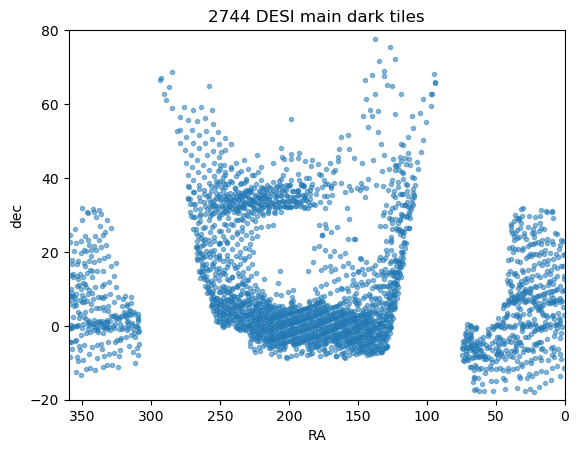

In [9]:
survey = 'main'
program = 'dark'
maindark = (tiles_table['SURVEY']==survey) & (tiles_table['PROGRAM']==program)
maindark_tiles = tiles_table[maindark]
tilera = maindark_tiles['TILERA']
tiledec = maindark_tiles['TILEDEC']
ntiles = len(maindark_tiles)

plt.plot(tilera, tiledec, '.', alpha=0.5)
plt.xlim(360, 0)
plt.ylim(-20, 80)
plt.xlabel('RA')
plt.ylabel('dec')
plt.title(f'{ntiles} DESI {survey} {program} tiles')

#### Suggested Exercises

1. Plot the TILERA, TILEDEC distribution for other SURVEY/PROGRAM combinations, e.g. sv3/dark
2. Load a different production than loa, e.g. iron or kibo.  How do they differ in tile coverage?
3. Sort by LASTNIGHT and make a cumulative histogram vs. time to see the growth in number of tiles observed.

## Redshift Catalogs

The redshift catalogs in the `zcatalog/v1` directory:

In [10]:
sorted(os.listdir(f'{specprod_dir}/zcatalog/v1'))

['redux_iron_zcatalog_v1.sha256sum',
 'zall-pix-iron.fits',
 'zall-tilecumulative-iron.fits',
 'zpix-cmx-other.fits',
 'zpix-main-backup.fits',
 'zpix-main-bright.fits',
 'zpix-main-dark.fits',
 'zpix-special-backup.fits',
 'zpix-special-bright.fits',
 'zpix-special-dark.fits',
 'zpix-special-other.fits',
 'zpix-sv1-backup.fits',
 'zpix-sv1-bright.fits',
 'zpix-sv1-dark.fits',
 'zpix-sv1-other.fits',
 'zpix-sv2-backup.fits',
 'zpix-sv2-bright.fits',
 'zpix-sv2-dark.fits',
 'zpix-sv3-backup.fits',
 'zpix-sv3-bright.fits',
 'zpix-sv3-dark.fits',
 'ztile-cmx-other-cumulative.fits',
 'ztile-cmx-other-pernight.fits',
 'ztile-main-backup-cumulative.fits',
 'ztile-main-bright-cumulative.fits',
 'ztile-main-dark-cumulative.fits',
 'ztile-special-backup-cumulative.fits',
 'ztile-special-bright-cumulative.fits',
 'ztile-special-dark-cumulative.fits',
 'ztile-special-dark-pernight.fits',
 'ztile-special-other-cumulative.fits',
 'ztile-sv1-backup-cumulative.fits',
 'ztile-sv1-backup-pernight.fits'

That's a lot of catalogs!  What are these?

The catalogs are divided into `zpix`, `ztile`, and `zall` files.
  * `zpix-{survey}-{program}.fits`: redshifts fit to coadditions of all observations of each target within a given _survey_ and _program_, including combining information across tiles.
  * `ztile-{survey}-{program}-cumulative.fits`: redshifts fit to coadditions of all observations of each target on a given _tile_, but not combining information across tiles.
  * `zall-pix-{specprod}.fits`: combining all `zpix` catalogs and adding information about which spectra are the best quality when the same target is observed under multiple _survey_ and _program_s.
  * `zall-tilecumulative-{specprod}.fits`: like `zall-pix`, but stacking the `ztile` catalogs.

**Pro Tip**: for the purposes of Y3 analyses, you probably care about the `*-main-dark*.fits` or `*-main-bright*.fits` files.  The others are for more specialized analyses.

**Pro Tip**: these catalogs have an overwhelming number of columns.
See the data model [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/index.html)
to understand what the columns mean and which ones you actually care about.

The `03_RedshiftCatalogs.ipynb` notebook will cover what is actually in those catalogs.

**Detail**: why `zcatalog/v1` and not just `zcatalog/`?  This gives us the ability update the format of future zcatalogs and add them to a production without breaking script using the current v1 catalogs.
e.g. a set of "v2" catalogs is in progress which will bring in additional quality information used by LSS analyses.

## Spectra

Spectra are grouped in two formed: by _tile_ and by _healpix_.

### Tile-based spectra in `tiles/`

The spectra that coadd and fit information for individual tiles are in the
`tiles/cumulative/TILEID/LASTNIGHT/` directory.

"cumulative" refers to combining all data taken through a given night,
and "LASTNIGHT" is the YEARMMDD date of the sunset prior to observations,
i.e. it doesn't suddenly change at midnight.

In [11]:
tiles_dir = f'{specprod_dir}/tiles/cumulative'
ntiles_in_dir = len(os.listdir(tiles_dir))
ntiles_in_table = len(np.unique(tiles_table['TILEID']))
print(f'There are {ntiles_in_dir} tiles in {tiles_dir}')
print(f'Hopefully this matches the {ntiles_in_table} unique TILEID entries in {os.path.basename(tiles_file)}')

There are 6101 tiles in /dvs_ro/cfs/cdirs/desi/spectro/redux/iron/tiles/cumulative
Hopefully this matches the 6101 unique TILEID entries in tiles-iron.csv


Let's look at the files in one specific main-dark tile

In [12]:
is_main_dark = (tiles_table['SURVEY']=='main') & (tiles_table['PROGRAM']=='dark')
tiles_table['TILEID', 'SURVEY', 'PROGRAM', 'LASTNIGHT'][is_main_dark][0:5]

TILEID,SURVEY,PROGRAM,LASTNIGHT
int64,str7,str6,int64
2196,main,dark,20210514
1404,main,dark,20210514
1750,main,dark,20210514
1751,main,dark,20210514
1433,main,dark,20210514


In [13]:
tileid = tiles_table['TILEID'][is_main_dark][0]
lastnight = tiles_table['LASTNIGHT'][is_main_dark][0]
tile_dir = f'{specprod_dir}/tiles/cumulative/{tileid}/{lastnight}'
print(f'files in {tile_dir}:')
sorted(os.listdir(tile_dir))

files in /dvs_ro/cfs/cdirs/desi/spectro/redux/iron/tiles/cumulative/2196/20210514:


['coadd-0-2196-thru20210514.fits',
 'coadd-1-2196-thru20210514.fits',
 'coadd-2-2196-thru20210514.fits',
 'coadd-3-2196-thru20210514.fits',
 'coadd-4-2196-thru20210514.fits',
 'coadd-5-2196-thru20210514.fits',
 'coadd-6-2196-thru20210514.fits',
 'coadd-7-2196-thru20210514.fits',
 'coadd-8-2196-thru20210514.fits',
 'coadd-9-2196-thru20210514.fits',
 'emline-0-2196-thru20210514.fits',
 'emline-1-2196-thru20210514.fits',
 'emline-2-2196-thru20210514.fits',
 'emline-3-2196-thru20210514.fits',
 'emline-4-2196-thru20210514.fits',
 'emline-5-2196-thru20210514.fits',
 'emline-6-2196-thru20210514.fits',
 'emline-7-2196-thru20210514.fits',
 'emline-8-2196-thru20210514.fits',
 'emline-9-2196-thru20210514.fits',
 'logs',
 'qso_mgii-0-2196-thru20210514.fits',
 'qso_mgii-1-2196-thru20210514.fits',
 'qso_mgii-2-2196-thru20210514.fits',
 'qso_mgii-3-2196-thru20210514.fits',
 'qso_mgii-4-2196-thru20210514.fits',
 'qso_mgii-5-2196-thru20210514.fits',
 'qso_mgii-6-2196-thru20210514.fits',
 'qso_mgii-7-21

That's a lot of output files for a single tile!  These follow the filename format
```
PREFIX-PETAL-TILEID-thruLASTNIGHT.*
```
See the [datamodel](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/tiles/GROUPTYPE/TILEID/GROUPID/index.html) for details about the formats of these files.  A quick summary of the prefixes is
* **spectra**: uncoadded spectra
* **coadd**: coadded spectra combining information across multiple exposures
* **redrock**: redshift fits
* **rrdetails**: detailed Redrock information, e.g. second best fits
* **rrmodel**: the Redrock best-fit models
* **emline**: simple Gaussian fits to emission lines based upon their expected location given the redshift
* **qso_qn**: QuasarNet output (fit to all targets, not just those targeted as QSOs or identified by Redrock as QSOs)
* **qso_mgii**: [MgII] fits (like qso_qn, this is run on all targets)
* **zmtl**: information used for updating the "Merged Target List" for operations


The `04_Spectra.ipynb` notebook goes into more details about reading and plotting these files.

## Cross-tile spectra in the `healpix/` directory

The `healpix/` directory contains the same type of spectra, coadd, redrock, emline, etc. files, but in this case they combine information across overlapping tiles.

Healpix is a hierarchical tiling, and we use "nside=64" which corresponds to pixels of 0.84 square degrees such that O(10) healpix cover a single tile.

To protect the different sub-programs of DESI from each other, they are still split by SURVEY and PROGRAM.  Additionally, since there are O(20k) nside=64 healpix covering DESI, these are grouped into subdirs of `HPIXGROUP=HEALPIX//100`.  The full directory path is
```
healpix/SURVEY/PROGRAM/HPIXGROUP/HEALPIX/
```
Let's explore that.

In [14]:
healpix_dir = f'{specprod_dir}/healpix'
sorted(os.listdir(healpix_dir))

['cmx',
 'main',
 'redux_iron_healpix.sha256sum',
 'special',
 'sv1',
 'sv2',
 'sv3',
 'tilepix.fits',
 'tilepix.json']

The `tilepix.*` files map which tiles are covered by this healpixels.

The subdirectories are for individual SURVEYs.  Under each SURVEY are the list of PROGRAMs observed by that SURVEY:

In [15]:
sorted(os.listdir(f'{healpix_dir}/main'))

['backup', 'bright', 'dark']

In [16]:
survey = 'main'
program = 'dark'
healpix_dirs = sorted(glob.glob(f'{healpix_dir}/main/dark/*/*'))
nhealpix = len(healpix_dirs)
print(f'DESI SURVEY={survey} PROGRAM={program} covers {nhealpix} healpix')

DESI SURVEY=main PROGRAM=dark covers 13494 healpix


Looking at just one of those directories:

In [17]:
print(f'Files in {healpix_dirs[1000]}')
sorted(os.listdir(healpix_dirs[1000]))

Files in /dvs_ro/cfs/cdirs/desi/spectro/redux/iron/healpix/main/dark/125/12563


['coadd-main-dark-12563.fits',
 'emline-main-dark-12563.fits',
 'hpixexp-main-dark-12563.csv',
 'logs',
 'qso_mgii-main-dark-12563.fits',
 'qso_qn-main-dark-12563.fits',
 'redrock-main-dark-12563.fits',
 'redux_iron_healpix_main_dark_125_12563.sha256sum',
 'rrdetails-main-dark-12563.h5',
 'spectra-main-dark-12563.fits.gz']

These have the same basic files as the tiles-based spectra, but in this case there
is only one file for each prefix for each healpix.

**Note**: since DESI doesn't cover the full sky, it doesn't cover all healpix, and the 1000th healpix directory was *not* HEALPIX=1000.

**Note**: since each healpix can have a different number of overlapping tiles, each healpix directory can have a varying number of targets, ranging from a single target to many thousands.

The `04_Spectra.ipynb` notebook goes into more details about reading and plotting these files.

## Summary

* When working with DESI data, set your `specprod` (e.g. loa) and base directory `DESI_ROOT_READONLY/spectro/redux/{specprod}` once at the top of your script to make it easier to update to future productions and non-NERSC processing.
* Under a `specprod_dir`,
  * Redshift catalogs are in `zcatalog/v1`
  * Tile-based spectra are in `tiles/cumulative/TILEID/LASTNIGHT/`
  * Cross-tile healpix-organized spectra are in `healpix/SURVEY/PROGRAM/HPIXGROUP/HEALPIX/`